<a href="https://colab.research.google.com/github/MathiasSchindlerCPH/BSE-T2-CML2-repo/blob/main/InClass-2-prep/InClass_2_prep_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **In-Class Preparation 2: Support Vector Machines**

---



*Preparation for In-Class Assignment* 1 covering Support Vector Machines (henceforth, SVM) algorithms.

NB: Notebook is based on [https://www.kaggle.com/prashant111/svm-classifier-tutorial](https://www.kaggle.com/prashant111/svm-classifier-tutorial).

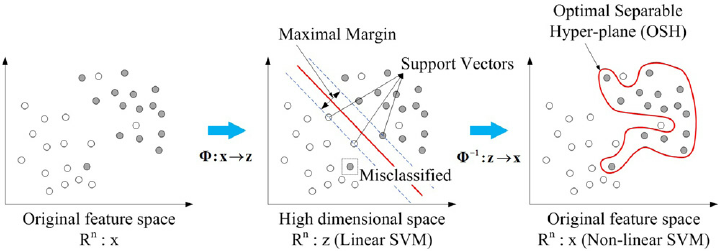

Course: Computation Machine Learning 2

Student: Mathias Schindler

Structure of this notebooks (i.e. the sectioning) follows the ordinary evaluation criteria for In-Class Assignments.

## 0. Preamble

In [166]:
# clear everything
%reset -f
print(dir())

['In', 'Out', '__builtin__', '__builtins__', '__name__', '_dh', '_ih', '_oh', '_sh', 'exit', 'get_ipython', 'quit']


In [167]:
# Mount G Drive
from google.colab import drive
drive.mount('/content/drive')

# Set path
import os
os.chdir('/content/drive/My Drive/--T2-CML2')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [168]:
!ls

1-nearest_neighbors  _CML2_materials	 InClass-preps	      utils
1-prepostprocessing  CML-TA1_Notes.gdoc  InClass-submissions
2-svm		     Data		 Project1_kNN


In [169]:
# Load packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, auc, roc_curve, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [170]:
from utils.helper_functions import *

In [171]:
# Load custom functions
from Project1_kNN import mschindler_functions_v4 as my_fcts
dir(my_fcts)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'construct_age_admit',
 'datetime',
 'make_feat_importance_plot',
 'make_multi_point_pred',
 'make_nan_fig',
 'make_roc_plot',
 'make_scree_plot',
 'np',
 'p_hat_plot',
 'pd',
 'plot_confusion_matrix',
 'plt',
 'reweight',
 'reweight_proba_multi',
 'sns',
 'timedelta']

# **1. Code runs**

Make sure of this before submission.

# **2. Data Preparation**

In [172]:
data = pd.read_csv('https://raw.githubusercontent.com/alexandrehsd/Predicting-Pulsar-Stars/master/pulsar_stars.csv')

## 2.1 Specific-Purpose: Rename Columns

In [173]:
# Two lists
old_cols = [' Mean of the integrated profile', ' Standard deviation of the integrated profile',
       ' Excess kurtosis of the integrated profile', ' Skewness of the integrated profile', ' Mean of the DM-SNR curve',
       ' Standard deviation of the DM-SNR curve', ' Excess kurtosis of the DM-SNR curve', ' Skewness of the DM-SNR curve',
       'target_class']
new_cols = ['IP_Mean', 'IP_Sd', 'IP_Kurtosis', 'IP_Skewness', 'DM-SNR Mean', 'DM-SNR Sd', 'DM-SNR Kurtosis', 'DM-SNR Skewness', 'target_class']

# Lists into dict
cols = {}
for key in old_cols:
    for value in new_cols:
        cols[key] = value
        new_cols.remove(value)
        break

# Rename cols
data = data.rename(cols, axis = 1)
data

,IP_Mean,IP_Sd,IP_Kurtosis,IP_Skewness,DM-SNR Mean,DM-SNR Sd,DM-SNR Kurtosis,DM-SNR Skewness,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0
...,...,...,...,...,...,...,...,...,...
17893,136.429688,59.847421,-0.187846,-0.738123,1.296823,12.166062,15.450260,285.931022,0
17894,122.554688,49.485605,0.127978,0.323061,16.409699,44.626893,2.945244,8.297092,0
17895,119.335938,59.935939,0.159363,-0.743025,21.430602,58.872000,2.499517,4.595173,0
17896,114.507812,53.902400,0.201161,-0.024789,1.946488,13.381731,10.007967,134.238910,0


## 2.1 Exploratory Analysis

In [174]:
# Set target
y = data['target_class']

data = data.drop(['target_class'], axis = 1)

In [175]:
# data shape
print('Shape: '+ str(data.shape) + '\n'); 

# inspect columns
print('Columns: \n' + str(data.columns) + '\n')

# data types
print('Data Types: \n' + str(data.dtypes) )

Shape: (17898, 8)

Columns: 
Index(['IP_Mean', 'IP_Sd', 'IP_Kurtosis', 'IP_Skewness', 'DM-SNR Mean',
       'DM-SNR Sd', 'DM-SNR Kurtosis', 'DM-SNR Skewness'],
      dtype='object')

Data Types: 
IP_Mean            float64
IP_Sd              float64
IP_Kurtosis        float64
IP_Skewness        float64
DM-SNR Mean        float64
DM-SNR Sd          float64
DM-SNR Kurtosis    float64
DM-SNR Skewness    float64
dtype: object


In [176]:
# summary statistics
print('Summary stats: \n')
data.describe().applymap(lambda x: f"{x:0.2f}") #<- .applymap(...) for 2 decimals

#round(data.describe(),2)

Summary stats: 



,IP_Mean,IP_Sd,IP_Kurtosis,IP_Skewness,DM-SNR Mean,DM-SNR Sd,DM-SNR Kurtosis,DM-SNR Skewness
count,17898.00,17898.00,17898.00,17898.00,17898.00,17898.00,17898.00,17898.00
mean,111.08,46.55,0.48,1.77,12.61,26.33,8.30,104.86
std,25.65,6.84,1.06,6.17,29.47,19.47,4.51,106.51
min,5.81,24.77,-1.88,-1.79,0.21,7.37,-3.14,-1.98
25%,100.93,42.38,0.03,-0.19,1.92,14.44,5.78,34.96
50%,115.08,46.95,0.22,0.20,2.80,18.46,8.43,83.06
75%,127.09,51.02,0.47,0.93,5.46,28.43,10.70,139.31
max,192.62,98.78,8.07,68.10,223.39,110.64,34.54,1191.00


AxesSubplot(0.125,0.125;0.775x0.755)
0    0.908426
1    0.091574
Name: target_class, dtype: float64




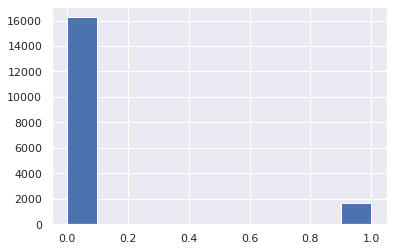

In [177]:
# distribution of target
print(y.hist() ); print(y.value_counts() / len(y) ); print('\n')

Text(0, 0.5, 'Number of pulsar stars')

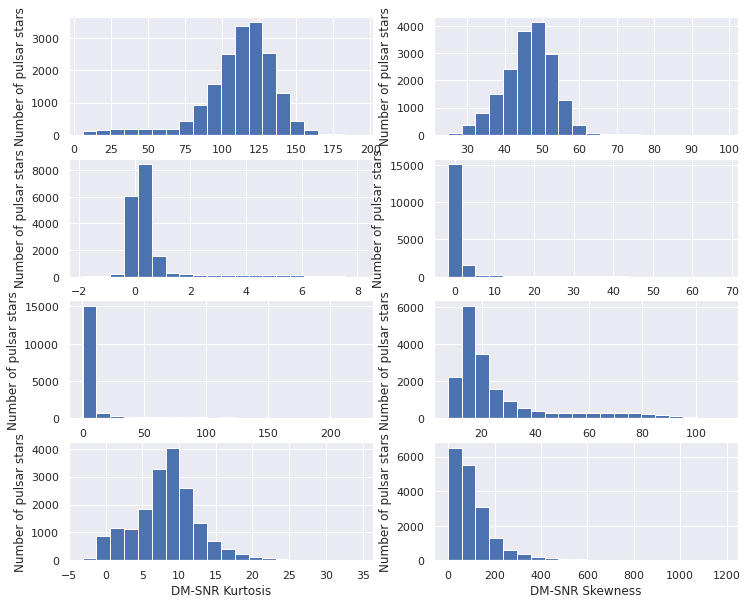

In [178]:
# Distribution of features
plt.figure(figsize=(12,10))

plt.subplot(4, 2, 1); fig = data['IP_Mean'].hist(bins=20)
fig.set_xlabel('IP_Mean'); fig.set_ylabel('Number of pulsar stars')
plt.subplot(4, 2, 2); fig = data['IP_Sd'].hist(bins=20); fig.set_xlabel('IP_Sd'); fig.set_ylabel('Number of pulsar stars')
plt.subplot(4, 2, 3); fig = data['IP_Kurtosis'].hist(bins=20)
fig.set_xlabel('IP_Kurtosis')
fig.set_ylabel('Number of pulsar stars')
plt.subplot(4, 2, 4); fig = data['IP_Skewness'].hist(bins=20); fig.set_xlabel('IP_Skewness'); fig.set_ylabel('Number of pulsar stars')
plt.subplot(4, 2, 5); fig = data['DM-SNR Mean'].hist(bins=20); fig.set_xlabel('DM-SNR Mean'); fig.set_ylabel('Number of pulsar stars')
plt.subplot(4, 2, 6); fig = data['DM-SNR Sd'].hist(bins=20); fig.set_xlabel('DM-SNR Sd'); fig.set_ylabel('Number of pulsar stars')
plt.subplot(4, 2, 7); fig = data['DM-SNR Kurtosis'].hist(bins=20); fig.set_xlabel('DM-SNR Kurtosis'); fig.set_ylabel('Number of pulsar stars')
plt.subplot(4, 2, 8); fig = data['DM-SNR Skewness'].hist(bins=20); fig.set_xlabel('DM-SNR Skewness'); fig.set_ylabel('Number of pulsar stars')

#data.hist()

## 2.2 Missing Values Imputation

In [179]:
# Inspect missing values
data.isnull().sum()

IP_Mean            0
IP_Sd              0
IP_Kurtosis        0
IP_Skewness        0
DM-SNR Mean        0
DM-SNR Sd          0
DM-SNR Kurtosis    0
DM-SNR Skewness    0
dtype: int64

Is this case *none* are missing. Boxplots below show we have outliers, however.

Text(0, 0.5, 'DM-SNR Skewness')

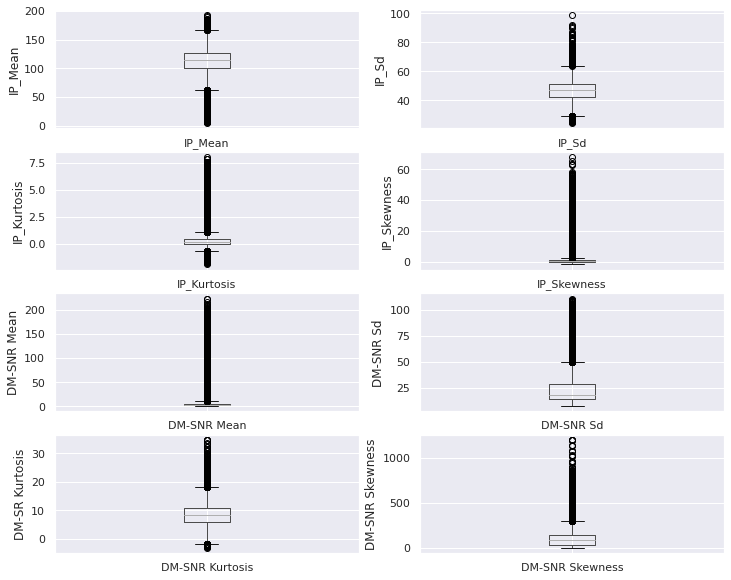

In [180]:
plt.figure(figsize=(12,10))

plt.subplot(4, 2, 1); fig = data.boxplot(column='IP_Mean'); fig.set_title(''); fig.set_ylabel('IP_Mean')
plt.subplot(4, 2, 2); fig = data.boxplot(column='IP_Sd'); fig.set_title(''); fig.set_ylabel('IP_Sd')
plt.subplot(4, 2, 3); fig = data.boxplot(column='IP_Kurtosis'); fig.set_title(''); fig.set_ylabel('IP_Kurtosis')
plt.subplot(4, 2, 4); fig = data.boxplot(column='IP_Skewness'); fig.set_title(''); fig.set_ylabel('IP_Skewness')
plt.subplot(4, 2, 5); fig = data.boxplot(column='DM-SNR Mean'); fig.set_title(''); fig.set_ylabel('DM-SNR Mean')
plt.subplot(4, 2, 6); fig = data.boxplot(column='DM-SNR Sd'); fig.set_title(''); fig.set_ylabel('DM-SNR Sd')
plt.subplot(4, 2, 7); fig = data.boxplot(column='DM-SNR Kurtosis'); fig.set_title(''); fig.set_ylabel('DM-SR Kurtosis')
plt.subplot(4, 2, 8); fig = data.boxplot(column='DM-SNR Skewness'); fig.set_title(''); fig.set_ylabel('DM-SNR Skewness')

## 2.3 Numerical Features

In this case *all* features are numerical.

## 2.4 Categorical Features

In this case *none* features are categorical.

## 2.5 Concatenating

Not necessary.

# **3. Preprocessing**

## 3.0 Splitting

In [181]:
X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

## 3.1 Standardization

In [182]:
# save columns
cols = X_train.columns

In [183]:
# Instantiate
scl = StandardScaler()

# Fit
scl.fit(X_train)

# Transform
X_train = scl.transform(X_train)
X_test = scl.transform(X_test)

# Format
X_train, X_test = pd.DataFrame(X_train, columns= cols), pd.DataFrame(X_test, columns= cols)

In [184]:
X_train.head()
#X_test.head()

,IP_Mean,IP_Sd,IP_Kurtosis,IP_Skewness,DM-SNR Mean,DM-SNR Sd,DM-SNR Kurtosis,DM-SNR Skewness
0,0.377102,0.186432,-0.213043,-0.303767,-0.162367,0.445494,-0.764988,-0.762900
1,0.219585,0.311963,-0.268826,-0.252348,-0.329485,-0.502235,-0.023698,-0.184681
2,-1.699540,1.699078,1.248413,0.094819,2.027133,2.764156,-1.688753,-0.993425
3,-0.676429,-1.788178,0.157113,0.176569,-0.304813,-0.216554,-0.183040,-0.408275
4,-0.443917,0.302114,-0.016524,-0.250519,-0.374223,-0.677774,0.643273,0.491991


# **4. SVM Usage**

Because the data contains outliers we should use `soft-margin variant of SVM` instead of `hard-margin variant of SVM` (which doesn't deal with outliers).
<br>
With `soft-margin variant of SVM` we should use a high value of `C` which implies less outliers.

## 4.1 Separable Case

In [185]:
%%time
# Instantiate 
svc = SVC(C=1,  kernel='rbf')         #'rbf' is default
svc100 = SVC(C=100,  kernel='rbf') 
svc1000 = SVC(C=1000,  kernel='rbf') 

linear_svc = SVC(kernel='linear', C=1) 
linear_svc100 = SVC(kernel='linear', C=100) 
linear_svc1000 = SVC(kernel='linear', C=1000) 

poly_svc = SVC(kernel='poly', C=1) 
poly_svc100 = SVC(kernel='poly', C=10) 
poly_svc1000 = SVC(kernel='poly', C=1000) 

sigmoid_svc = SVC(kernel='sigmoid', C=1) 
sigmoid_svc100 = SVC(kernel='sigmoid', C=100) 
sigmoid_svc1000 = SVC(kernel='sigmoid', C=1000) 

#Predict
svc.fit(X_train,y_train)
svc100.fit(X_train,y_train)
svc1000.fit(X_train,y_train)

linear_svc.fit(X_train,y_train)
linear_svc100.fit(X_train,y_train)
linear_svc1000.fit(X_train,y_train)

poly_svc.fit(X_train,y_train)
poly_svc100.fit(X_train,y_train)
poly_svc1000.fit(X_train,y_train)

sigmoid_svc.fit(X_train,y_train)
sigmoid_svc100.fit(X_train,y_train)
sigmoid_svc1000.fit(X_train,y_train)

CPU times: user 3min 5s, sys: 277 ms, total: 3min 5s
Wall time: 3min 5s
Parser   : 145 ms


In [ ]:
# predict
y_pred = svc.predict(X_test); print('Model accuracy score with rbf hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
y_pred = svc100.predict(X_test); print('Model accuracy score with rbf kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
y_pred = svc1000.predict(X_test); print('Model accuracy score with rbf kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

y_pred = linear_svc.predict(X_test); print('Model accuracy score with linear kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
y_pred = linear_svc100.predict(X_test); print('Model accuracy score with linear kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
y_pred = linear_svc1000.predict(X_test); print('Model accuracy score with linear kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

y_pred = poly_svc.predict(X_test); print('Model accuracy score with polynomial kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
y_pred = poly_svc100.predict(X_test); print('Model accuracy score with polynomial kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
y_pred = poly_svc1000.predict(X_test); print('Model accuracy score with polynomial kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

y_pred = sigmoid_svc.predict(X_test); print('Model accuracy score with sigmoid kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
y_pred = sigmoid_svc100.predict(X_test); print('Model accuracy score with sigmoid kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
y_pred = sigmoid_svc1000.predict(X_test); print('Model accuracy score with sigmoid kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 0.9827
Model accuracy score with rbf kernel and C=100.0 : 0.9832
Model accuracy score with rbf kernel and C=1000.0 : 0.9816
Model accuracy score with linear kernel and C=1.0 : 0.9830
Model accuracy score with linear kernel and C=100.0 : 0.9832
Model accuracy score with linear kernel and C=1000.0 : 0.9832
Model accuracy score with polynomial kernel and C=1.0 : 0.9807
Model accuracy score with polynomial kernel and C=100.0 : 0.9830
Model accuracy score with polynomial kernel and C=1000.0 : 0.9838
Model accuracy score with sigmoid kernel and C=1.0 : 0.8858
Model accuracy score with sigmoid kernel and C=100.0 : 0.8855
Model accuracy score with sigmoid kernel and C=1000.0 : 0.8855


## 4.2 Non-Separable Case

# **5. Making Test Prediction**

# **6. Accuracy**

Kaggle will report but can compute some in-sample metrics as here:

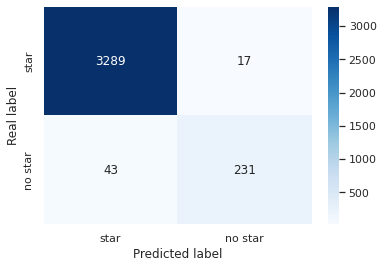

In [ ]:
linear_svc100 = SVC(kernel='linear', C=100) 
linear_svc100.fit(X_train, y_train)
y_pred = linear_svc100.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['star', 'no star'])

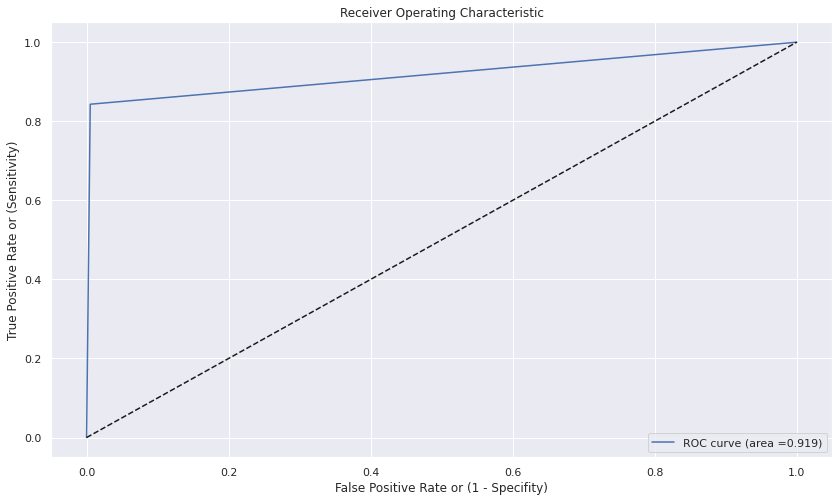

In [ ]:
fpr, tpr, thrs = roc_curve(y_test, y_pred)
roc_auc_score = auc(fpr, tpr)

# Plot
my_fcts.make_roc_plot(fpr, tpr, roc_auc_score)

# **7. Hyperparameter Optimization**

In [ ]:
%%time
# pipeline

# declare parameters for hyperparameter tuning
parameters = [ {'C':[1, 10, 100, 1000], 'kernel':['linear']},
               {'C':[1, 10, 100, 1000], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
               {'C':[1, 10, 100, 1000], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03,0.04,0.05]} 
              ]
svc=SVC() 

# Instantiate grid search
grid_search = RandomizedSearchCV(estimator = svc,  
                           #param_grid = parameters, #<- for GridSearchCV
                           param_distributions = parameters,
                           #scoring = 'accuracy',
                           scoring ='roc_auc',
                           cv = 5,
                           verbose=0)

# Fit grid
grid_search.fit(X_train, y_train)


# Results score achieved during the GridSearchCV
print('GridSearch CV best score: {:.4f}\n'.format(grid_search.best_score_))
print('\n Parameters that give the best results:','\n', (grid_search.best_params_))
print('\n\nEstimator that was chosen by the search:','\n', (grid_search.best_estimator_))
print('\n GridSearch CV score on test set: {0:0.4f}'.format(grid_search.score(X_test, y_test)))
print('\n\n')

GridSearch CV best score : 0.9629


 Parameters that give the best results : 
 {'kernel': 'poly', 'gamma': 0.01, 'degree': 3, 'C': 1000}


Estimator that was chosen by the search : 
 SVC(C=1000, gamma=0.01, kernel='poly')

 GridSearch CV score on test set: 0.9617



CPU times: user 1min 20s, sys: 279 ms, total: 1min 20s
Wall time: 1min 21s


# 99. Kaggle Export

Starter notebook will include code snippet for dataframe formatting

# Appendix: Ad-Hoc Functions

## A.1. Compare Columns in Train and Test

In [ ]:
%%script false

# Data type: pd.DataFrames
train_cols = df_train.columns
test_cols = df_test.columns

print('In train but not test: ' + str(train_cols.difference(test_cols)) )
print('In test but not train: ' + str(test_cols.difference(train_cols)) )

In [ ]:
%%script false

# Data type: List
train_cols = train.columns[train.isnull().any()].to_list()
test_cols = test.columns[test.isnull().any()].to_list()

print('In train but not test: ' + str(list(set(train_cols) - set(test_cols))) )
print('In test but not train: ' + str(list(set(test_cols) - set(train_cols))) )